# Pointwise Reliability: Density, Clustering - DBSCAN

## Workflow:
- Perform grid search over `eps` and `min_samples` 
  - Select the parameters that maximize the number of clusters
- Train DBSCAN
- Workflow Reliability:
  - Determines whether the new instance is part of a cluster (eps distance to any core point in the cluster)
  - Identifies which cluster the new instance would belong to based on its nearest core point
  - Calculates the size of the identified cluster 
  - Compute reliability:
    - reliability=  cluster_size / `minimum_cluster_units`
      - `minimum_cluster_units` <- param 
      - If the cluster size is larger than the threshold (minimum cluster units): reliability = 1
      - If the new instance is not part of any cluster: reliability = 0

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


###########################################################
# Load Classifier and Training Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("dataset/data_train.csv")

# Map labels and preprocess training data
y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train = training_data.drop(columns=['SOURCE'])

# Preprocess training data using the loaded pipeline
X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [2]:
###########################################################
# Train DBSCAN
###########################################################
eps_value = 0.06444444444444444
min_samples_value = 2

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
dbscan.fit(X_train_preprocessed)

core_samples_mask = dbscan.labels_ != -1  # Exclude noise (-1)
core_points = X_train_preprocessed[core_samples_mask]
core_labels = dbscan.labels_[core_samples_mask]

print(f"Number of clusters (excluding noise): {len(set(core_labels))}")
print(f"Number of core points: {len(core_points)}")

Number of clusters (excluding noise): 428
Number of core points: 1834


In [3]:
# Add cluster labels back to the original data
training_data['cluster'] = dbscan.labels_

cluster_counts = training_data['cluster'].value_counts().nlargest(10)

print("Top 10 Largest Clusters:")
cluster_counts

Top 10 Largest Clusters:


cluster
-1      2136
 0       233
 1       146
 32       90
 12       71
 28       32
 77       18
 117      16
 15       16
 122      15
Name: count, dtype: int64

In [4]:
# Display sample points from each of these top 10 clusters
for cluster_label in cluster_counts.index:
    cluster_data = training_data[training_data['cluster'] == cluster_label]
    
    cluster_name = "Noise" if cluster_label == -1 else f"Cluster {cluster_label}"
    
    print(f"\n{cluster_name} ({len(cluster_data)} instances):")
    print(cluster_data[['SOURCE', 'cluster']].head(10))


Noise (2136 instances):
   SOURCE  cluster
0     out       -1
3      in       -1
5      in       -1
6      in       -1
7     out       -1
8      in       -1
9     out       -1
10     in       -1
11     in       -1
13    out       -1

Cluster 0 (233 instances):
    SOURCE  cluster
1      out        0
19     out        0
31     out        0
39     out        0
50     out        0
67     out        0
72     out        0
91      in        0
113    out        0
153    out        0

Cluster 1 (146 instances):
    SOURCE  cluster
2      out        1
20      in        1
48     out        1
71     out        1
107     in        1
118    out        1
163    out        1
165    out        1
174    out        1
204    out        1

Cluster 32 (90 instances):
    SOURCE  cluster
119    out       32
121     in       32
132    out       32
185    out       32
211    out       32
241    out       32
248     in       32
358     in       32
410     in       32
411    out       32

Cluster 12 (71 instan

In [5]:

# Add cluster labels back to the original data
training_data['cluster'] = dbscan.labels_

# Count total instances per cluster (including noise)
cluster_counts = training_data['cluster'].value_counts().nlargest(10)

summary_data = []

for cluster_label in cluster_counts.index:
    cluster_data = training_data[training_data['cluster'] == cluster_label]
    
    count_label_0 = (cluster_data['SOURCE'] == 'out').sum()
    count_label_1 = (cluster_data['SOURCE'] == 'in').sum()
    
    summary_data.append({
        "Cluster ID": cluster_label,
        "Number of Instances": len(cluster_data),
        "Count Label 0": count_label_0,
        "Count Label 1": count_label_1
    })

pd.DataFrame(summary_data)

,Cluster ID,Number of Instances,Count Label 0,Count Label 1
0,-1,2136,1291,845
1,0,233,202,31
2,1,146,109,37
3,32,90,68,22
4,12,71,55,16
5,28,32,15,17
6,77,18,7,11
7,117,16,5,11
8,15,16,2,14
9,122,15,12,3


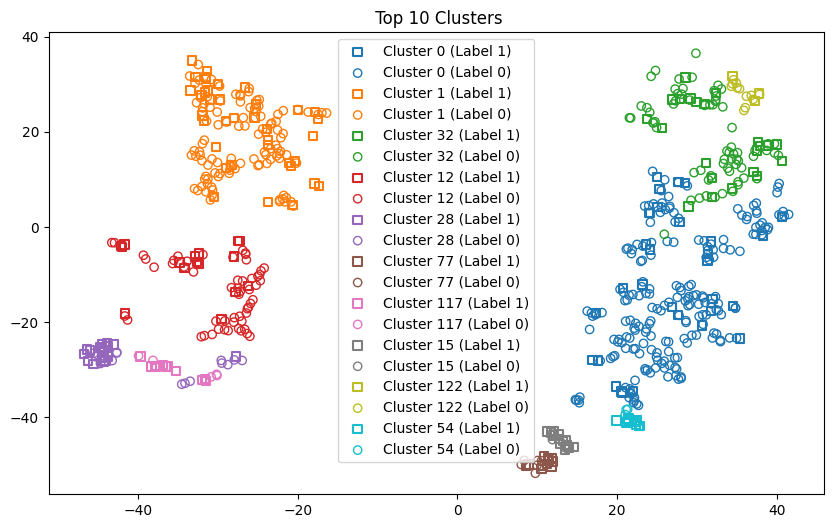

In [6]:
# Filter data for non-noise points only
non_noise_data = X_train_preprocessed[dbscan.labels_ != -1]
non_noise_labels = dbscan.labels_[dbscan.labels_ != -1]

tsne = TSNE(n_components=2, random_state=30, perplexity=25)
X_tsne = tsne.fit_transform(non_noise_data)

tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = non_noise_labels

tsne_df['SOURCE'] = y_train[dbscan.labels_ != -1].values 

# Identify the top 10 largest clusters
top_clusters = pd.Series(non_noise_labels).value_counts().nlargest(10).index
tsne_df_top = tsne_df[tsne_df['Cluster'].isin(top_clusters)]

colors = plt.cm.tab10(np.linspace(0, 1, 10))


plt.figure(figsize=(10, 6))
for idx, cluster_label in enumerate(top_clusters):
    cluster_data = tsne_df_top[tsne_df_top['Cluster'] == cluster_label]
    
    # Squares for label 1
    plt.scatter(
        cluster_data[cluster_data['SOURCE'] == 1]['TSNE1'],
        cluster_data[cluster_data['SOURCE'] == 1]['TSNE2'],
        marker='s',
        facecolors='none',
        edgecolors=colors[idx],
        linewidths=1.5,
        label=f'Cluster {cluster_label} (Label 1)'
    )

    # Circles for label 0
    plt.scatter(
        cluster_data[cluster_data['SOURCE'] == 0]['TSNE1'],
        cluster_data[cluster_data['SOURCE'] == 0]['TSNE2'],
        marker='o',
        facecolors='none',
        edgecolors=colors[idx],
        label=f'Cluster {cluster_label} (Label 0)'
    )

plt.title(' Top 10 Clusters')
plt.legend()
plt.show()
